In [84]:
%load_ext autoreload
%autoreload 2

In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Load data and split

In [54]:
# input_data = r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_w_labels.csv" ##data for proteins with AD/CN labels
input_data = r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_23Jun2025.csv"
train = pd.read_csv(input_data)
# target = 'research_group'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

# Simple preprocessing for unsupervised learning

Numerical feature preprocessing and fill empty cells - NO TARGET LABELS USED.

In [ ]:
# Numeric-only preprocessing: fill numeric NaNs with train-mean
nunique = train.nunique()
types = train.dtypes

# Fill numeric columns' NaNs with train split mean
exclude_for_filling = ['Set', 'subject_age', 'RID', 'VISCODE']  # Metadata columns
numeric_cols = [c for c in train.columns if c not in exclude_for_filling]

for col in numeric_cols:
    if pd.api.types.is_numeric_dtype(train[col]):
        mean_val = train.loc[train_indices, col].mean()
        train[col] = train[col].fillna(mean_val)

# No categorical features for embeddings
categorical_columns = []
categorical_dims = {}

# Define features for UNSUPERVISED pretraining (no target labels)

In [ ]:
exclude_cols = ['Set', 'subject_age', 'RID', 'VISCODE']  # Only exclude metadata
# Use only numeric columns as features for unsupervised learning
features = [
    col for col in train.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(train[col])
]
print(f"Number of features for unsupervised pretraining: {len(features)}")
# check that it is 320 features
# No categorical features used
cat_idxs = []
cat_dims = []


Number of features for unsupervised pretraining: 320


In [7]:
# For unsupervised pretraining, we only need X (features), no y (target)
X_train = train[features].values[train_indices]
# y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
# y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
# y_test = train[target].values[test_indices]

# Network parameters

In [8]:
from pytorch_tabnet.pretraining import TabNetPretrainer

In [9]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    n_shared_decoder=1, # nb shared glu for decoding
    n_indep_decoder=1, # nb independent glu for decoding
#     grouped_features=[[0, 1]], # you can group features together here
    verbose=5,
)

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Self Supervised Training

In [16]:
max_epochs = 150 if not os.getenv("CI", False) else 2 # 1000

In [17]:
unsupervised_model.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=max_epochs , patience=20,
    batch_size=128, virtual_batch_size=32,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.5,
) 

epoch 0  | loss: 1476.58902| val_0_unsup_loss_numpy: 5738.19189453125|  0:00:00s
epoch 5  | loss: 1262.25525| val_0_unsup_loss_numpy: 1839.155517578125|  0:00:02s
epoch 10 | loss: 770.77861| val_0_unsup_loss_numpy: 773.750244140625|  0:00:03s
epoch 15 | loss: 245.7871| val_0_unsup_loss_numpy: 1012.3229370117188|  0:00:04s
epoch 20 | loss: 75.53482| val_0_unsup_loss_numpy: 595.9057006835938|  0:00:05s
epoch 25 | loss: 19.31391| val_0_unsup_loss_numpy: 434.1187744140625|  0:00:06s
epoch 30 | loss: 8.71177 | val_0_unsup_loss_numpy: 137.62277221679688|  0:00:08s
epoch 35 | loss: 5.00891 | val_0_unsup_loss_numpy: 66.18266296386719|  0:00:11s
epoch 40 | loss: 2.6752  | val_0_unsup_loss_numpy: 40.56045150756836|  0:00:13s
epoch 45 | loss: 2.89374 | val_0_unsup_loss_numpy: 8.583820343017578|  0:00:15s
epoch 50 | loss: 2.06166 | val_0_unsup_loss_numpy: 6.584499835968018|  0:00:18s
epoch 55 | loss: 2.18958 | val_0_unsup_loss_numpy: 3.7453699111938477|  0:00:21s
epoch 60 | loss: 1.86553 | val_0_u

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Visualise explainability masks/heatmap

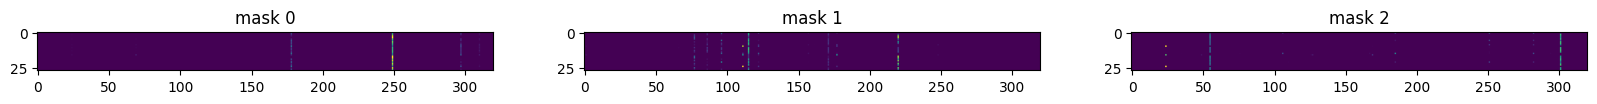

In [26]:
# Make reconstruction from a dataset and see the explainability matrix
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(X_valid)
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")



## Save and load the same way as other TabNet models

In [40]:
unsupervised_model.save_model(r'D:\ADNI\colab\test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model(r'D:\ADNI\colab\test_pretrain.zip')

Successfully saved model at D:\ADNI\colab\test_pretrain.zip


# Training for classification


In [34]:
#Load training data
input_data = r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_w_labels.csv" ##data for proteins with AD/CN labels
#input_data = r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_23Jun2025.csv"
train = pd.read_csv(input_data)
target = 'research_group'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

# Fill numeric columns' NaNs with train split mean
exclude_for_filling = ['Set', 'subject_age', 'RID', 'VISCODE']  # Metadata columns
numeric_cols = [c for c in train.columns if c not in exclude_for_filling]

exclude_cols = ['Set', 'subject_age', 'RID', 'VISCODE']  # Only exclude metadata
# Use only numeric columns as features for unsupervised learning
features = [
    col for col in train.columns
    if col not in exclude_cols and pd.api.types.is_numeric_dtype(train[col])
]
print(f"Number of features for unsupervised pretraining: {len(features)}")
# check that it is 320 features
# No categorical features used
cat_idxs = []
cat_dims = []

# For unsupervised pretraining, we only need X (features), no y (target)
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

Number of features for unsupervised pretraining: 320


In [35]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-3),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax', # This will be overwritten if using pretrain model
                       verbose=5,
                      )

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [50]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=64, virtual_batch_size=32,
    num_workers=0,
    weights=1,
    drop_last=False,
    # from_unsupervised=loaded_pretrain,
    
) 

epoch 0  | loss: 0.90737 | train_auc: 0.39962 | valid_auc: 0.64904 |  0:00:00s
epoch 5  | loss: 0.87662 | train_auc: 0.57287 | valid_auc: 0.43269 |  0:00:01s
epoch 10 | loss: 0.84743 | train_auc: 0.50751 | valid_auc: 0.47596 |  0:00:02s
epoch 15 | loss: 0.8007  | train_auc: 0.4329  | valid_auc: 0.46154 |  0:00:03s
epoch 20 | loss: 0.79462 | train_auc: 0.51114 | valid_auc: 0.55769 |  0:00:04s

Early stopping occurred at epoch 20 with best_epoch = 0 and best_valid_auc = 0.64904


c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


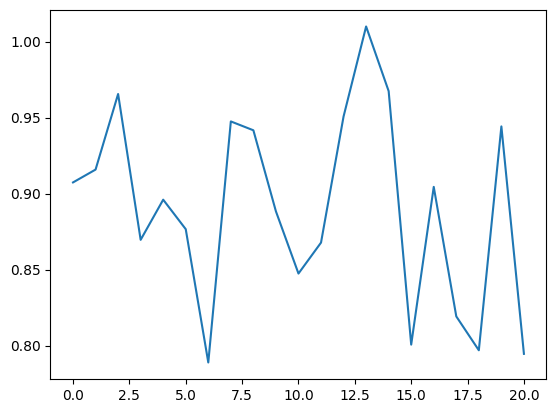

In [51]:
# plot losses
plt.plot(clf.history['loss'])

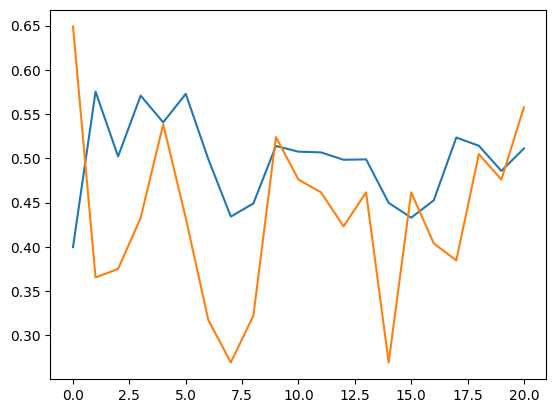

In [52]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

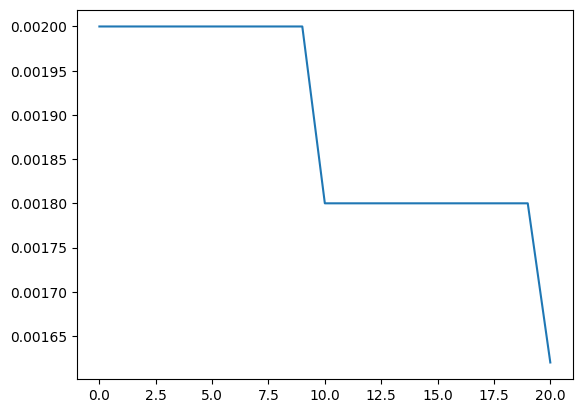

In [53]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [49]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR MRM proteomic : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR MRM proteomic : {test_auc}")

BEST VALID SCORE FOR MRM proteomic : 0.3846153846153846
FINAL TEST SCORE FOR MRM proteomic : 0.26666666666666666


In [104]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

# Save and load Model

In [68]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [69]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\adni-xNbsbYGy-py3.12\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [70]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR MRM proteomic: {loaded_test_auc}")

FINAL TEST SCORE FOR MRM proteomic: 0.525


In [71]:
assert(test_auc == loaded_test_auc)

In [ ]:
# DIAGNOSTIC: Compare pretraining vs supervised datasets
print("=== DATASET COMPARISON DIAGNOSTICS ===")

# Load both datasets for comparison
pretrain_data = pd.read_csv(r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\CSFMRM_23Jun2025.csv")
supervised_data = pd.read_csv(r"D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_w_labels.csv")

print(f"Pretraining dataset shape: {pretrain_data.shape}")
print(f"Supervised dataset shape: {supervised_data.shape}")

# Check feature overlap
pretrain_features = set(pretrain_data.columns) - {'RID', 'VISCODE', 'Set'}
supervised_features = set(supervised_data.columns) - {'RID', 'VISCODE', 'Set', 'research_group'}

common_features = pretrain_features & supervised_features
print(f"Common protein features: {len(common_features)}")
print(f"Pretrain-only features: {len(pretrain_features - supervised_features)}")
print(f"Supervised-only features: {len(supervised_features - pretrain_features)}")

# Check class distribution in supervised data
if 'research_group' in supervised_data.columns:
    class_dist = supervised_data['research_group'].value_counts()
    print(f"\nClass distribution in supervised data:")
    print(class_dist)
    print(f"Class balance ratio: {class_dist.min() / class_dist.max():.3f}")

# Check feature statistics comparison
common_feature_list = list(common_features)[:10]  # Sample 10 features
print(f"\nFeature statistics comparison (first 10 common features):")
for feat in common_feature_list:
    pretrain_mean = pretrain_data[feat].mean()
    supervised_mean = supervised_data[feat].mean()
    pretrain_std = pretrain_data[feat].std()
    supervised_std = supervised_data[feat].std()
    
    print(f"{feat[:30]:30s} | Pretrain: {pretrain_mean:8.3f}±{pretrain_std:6.3f} | Supervised: {supervised_mean:8.3f}±{supervised_std:6.3f}")

# Check missing value patterns
pretrain_missing = pretrain_data.isnull().sum().sum()
supervised_missing = supervised_data.isnull().sum().sum()
print(f"\nMissing values - Pretrain: {pretrain_missing}, Supervised: {supervised_missing}")

print("=" * 60)


# Global explainability : feat importance summing to 1

In [82]:
clf.feature_importances_

array([7.33116802e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.74157419e-07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.82996801e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.72733342e-04, 4.87473565e-04, 0.00000000e+00, 6.06443683e-06,
       0.00000000e+00, 3.11797385e-04, 0.00000000e+00, 0.00000000e+00,
       1.05130975e-04, 2.00491897e-03, 0.00000000e+00, 1.17456716e-03,
       3.16637713e-06, 0.00000000e+00, 6.62088980e-06, 0.00000000e+00,
       0.00000000e+00, 3.63111100e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.25685194e-05, 1.05153516e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.56936029e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.93330838e-07, 0.00000000e+00, 7.67914306e-02,
      

# Local explainability and masks

In [105]:
explain_matrix, masks = clf.explain(X_test)

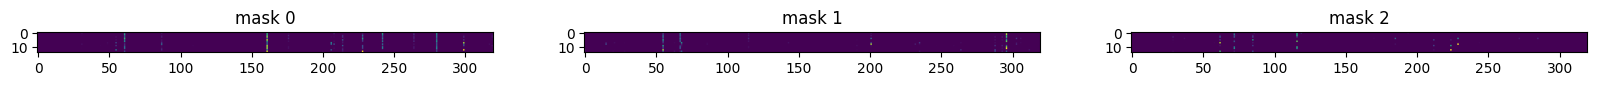

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


In [106]:
# Robust TabNet aggregation that works for pretraining and classifier
# - Normalizes masks to array of shape (n_steps, n_samples, n_features)
# - Uses eta weighting if per-step decision contributions are available
# - Falls back to equal weights when only global attributions are available

def _normalize_masks_to_array(masks):
    import numpy as _np
    # Already an ndarray
    if isinstance(masks, _np.ndarray):
        if masks.ndim == 3:
            return masks
        if masks.ndim == 2:
            return masks[None, ...]
    # List of arrays or dicts
    if isinstance(masks, list):
        arrs = []
        for m in masks:
            if isinstance(m, dict):
                if 'mask' in m:
                    m_arr = _np.asarray(m['mask'])
                elif 'M' in m:
                    m_arr = _np.asarray(m['M'])
                else:
                    m_arr = _np.asarray(next(iter(m.values())))
            else:
                m_arr = _np.asarray(m)
            arrs.append(m_arr)
        return _np.stack(arrs, axis=0)
    # Dict of step -> mask
    if isinstance(masks, dict):
        if 'masks' in masks:
            return _normalize_masks_to_array(masks['masks'])
        try:
            keys = sorted(masks.keys(), key=lambda k: int(str(k).split('_')[-1]))
        except Exception:
            keys = list(masks.keys())
        arrs = [_np.asarray(masks[k]) for k in keys]
        return _np.stack(arrs, axis=0)
    raise TypeError(f"Unsupported masks type: {type(masks)}")


def compute_tabnet_aggregate_importance(explain_matrix, masks):
    import numpy as _np
    masks_arr = _normalize_masks_to_array(masks)  # (n_steps, n_samples, n_features)
    n_steps, n_samples, n_features = masks_arr.shape

    # Try to build eta from per-step decision contributions if available
    eta = None
    if explain_matrix is not None:
        em = _np.asarray(explain_matrix)
        # If em has per-step decision contributions (n_samples, n_steps)
        if em.ndim == 2 and em.shape[1] == n_steps:
            eta = _np.maximum(em, 0).T  # (n_steps, n_samples)
    # Fallback: equal weights
    if eta is None:
        eta = _np.ones((n_steps, n_samples), dtype=float)

    eta3 = eta[:, :, None]  # (n_steps, n_samples, 1)

    # Numerator: sum_i eta_b[i] * M_{b,j}[i]
    numerator = (eta3 * masks_arr).sum(axis=0)  # (n_samples, n_features)

    # Denominator: sum_j sum_i eta_b[i] * (M_{b,j}[i])^2
    denom_per_feat = (eta3 * (masks_arr ** 2)).sum(axis=0)  # (n_samples, n_features)
    denominator = denom_per_feat.sum(axis=1, keepdims=True)  # (n_samples, 1)
    denominator = _np.where(denominator == 0, 1e-8, denominator)

    M_agg = numerator / denominator  # (n_samples, n_features)
    return M_agg, masks_arr

# Compute robust aggregate mask
M_agg, masks_arr = compute_tabnet_aggregate_importance(unsupervised_explain_matrix, unsupervised_masks)
print(f"Masks array shape: {masks_arr.shape}  (n_steps, n_samples, n_features)")
print(f"Aggregate mask shape: {M_agg.shape}  (n_samples, n_features)")

# Top features by average aggregated importance
feature_importance_tabnet = np.mean(M_agg, axis=0)
top_features_tabnet = np.argsort(feature_importance_tabnet)[::-1][:10]
print("\nTop 10 features (TabNet agg):")
for i, feat_idx in enumerate(top_features_tabnet):
    name = features[feat_idx] if 'features' in globals() and feat_idx < len(features) else feat_idx
    print(f"{i+1}. {name}: {feature_importance_tabnet[feat_idx]:.4f}")


Masks array shape: (3, 16, 320)  (n_steps, n_samples, n_features)
Aggregate mask shape: (16, 320)  (n_samples, n_features)

Top 10 features (TabNet agg):
1. CAD13_YEVSSPYFK: 0.2027
2. MIME_ESAYLYAR: 0.1914
3. CATD_LVDQNIFSFYLSR: 0.1799
4. NPTX2_TESTLNALLQR: 0.1608
5. NICA_ALADVATVLGR: 0.1392
6. AATC_NLDYVATSIHEAVTK: 0.1296
7. MUC18_GATLALTQVTPQDER: 0.0970
8. HBA_FLASVSTVLTSK: 0.0891
9. CCKN_NLQNLDPSHR: 0.0671
10. NPTX2_LESLEHQLR: 0.0479


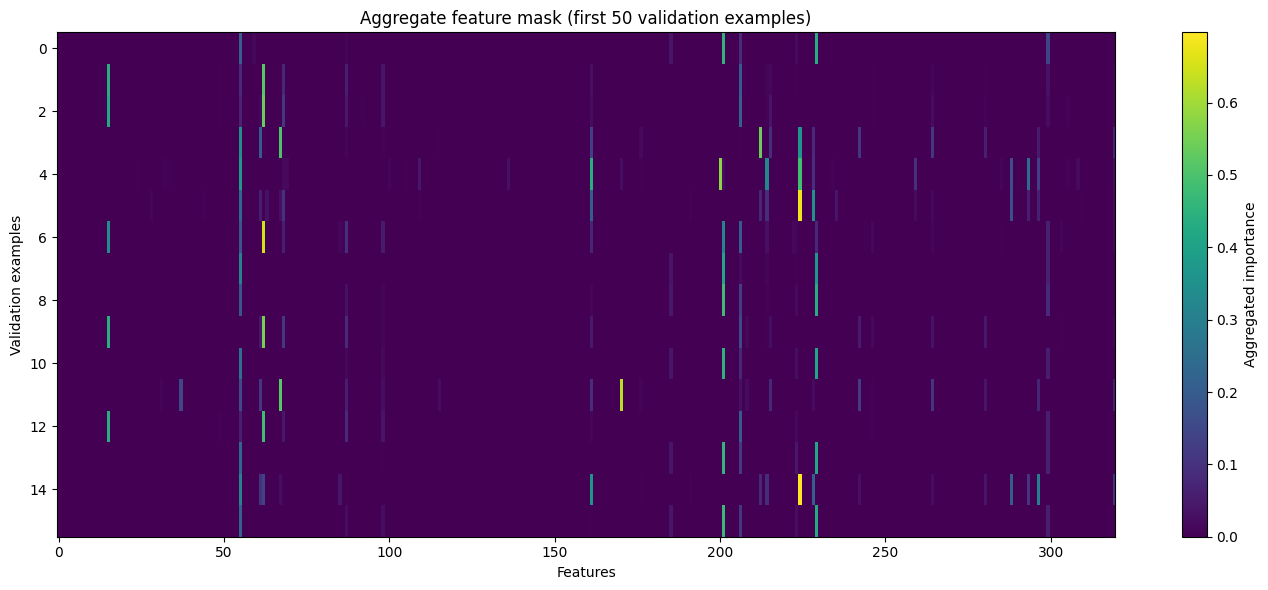

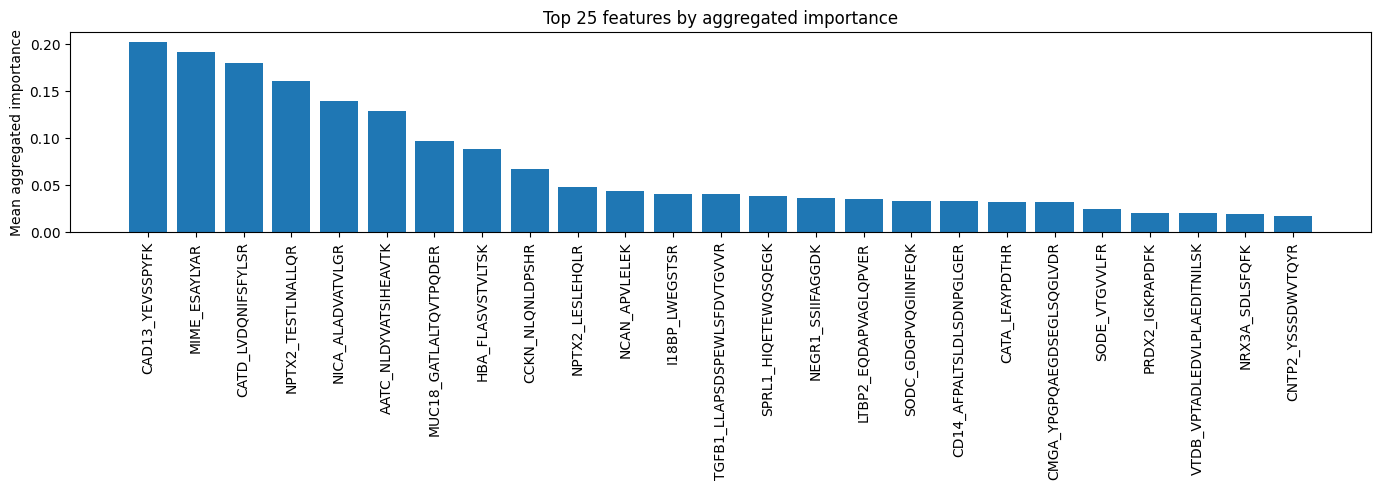

In [107]:
# Visualize aggregate mask (M_agg)
# 1) Heatmap of first 50 validation examples vs features
fig, ax = plt.subplots(figsize=(14, 6))
im = ax.imshow(M_agg[:50], aspect='auto', cmap='viridis')
ax.set_title('Aggregate feature mask (first 50 validation examples)')
ax.set_xlabel('Features')
ax.set_ylabel('Validation examples')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Aggregated importance')
plt.tight_layout()
plt.show()

# 2) Top-k features by average aggregated importance across validation set
feature_importance_tabnet = np.mean(M_agg, axis=0)
order = np.argsort(feature_importance_tabnet)[::-1]
TOP_K = min(25, len(order))
idx = order[:TOP_K]

# Resolve feature names if available
if 'features' in globals() and isinstance(features, (list, tuple)):
    xlabels = [str(features[i]) if i < len(features) else str(i) for i in idx]
else:
    xlabels = [str(i) for i in idx]

plt.figure(figsize=(14, 5))
plt.bar(range(TOP_K), feature_importance_tabnet[idx])
plt.xticks(range(TOP_K), xlabels, rotation=90)
plt.ylabel('Mean aggregated importance')
plt.title(f'Top {TOP_K} features by aggregated importance')
plt.tight_layout()
plt.show()
